# Recommend Fraud Score Cutoffs for Capital One 

Capital One has made the decision to not require KBA for all applicants. Given that KBA results are an input to the model, they have asked Amount to make an updated recommendation for which threshold(s) to use to escalate accounts into stricter identity tiers.

Given the nature of the POS product, we will not have bank account information at the time our fraud model is run either. This makes the inputs identical to those of Avant's credit card customers, and we can use that population to see if the missing attributes significantly shift fraud model scores to the extent that we would need to update our standard recommendations.

## Context 

> Hi Garrett Laird , to confirm, the purpose of this ticket is to recommend a fraud score threshold to segment COF customers between ID low and ID medium. The first step is to plot the distribution of fraud model scores for Avant credit card and compare against other products that use all inputs (incl. KBA, bank acct.). For Avant CC, we can do a threshold analysis to determine the optimal fraud score cutoff. Does that sound right? We can also collect demographic and other applicant data points to adjust the optimal Avant CC threshold if we believe the COF customer base is meaningfully different than the Avant CC customer base.

> everything mentioned above is correct. The one thing I’d add, is that we don’t need to limit ourselves to just 1 threshold separating low from medium risk applicants. If we also believe it would be worth while to include a 2nd threshold to place applicants into a high risk identity tier, that could also be included

## Steps

- Take all applications in Avant database, and add information on product type of application. 
- Plot the distribution of fraud scores for Avant credit card and compare them for other products (say Avant UIL)
- Look at characteristics of fraud above and below threshold for UIL products (% good, % bad, recall, precision, etc)
- At what threshold of fraud in CC product are the same charecteristics obtained? This is the new threshold that should be recommended, assuming that is the outcome we want. 

## Summary after Analysis

- The current cutoff of **0.05** captures 65% of all loan fraud (recall), marking 8.5% of negatives as fraud (false positives). Applying the same cutoff to credit cards, while it would capture 97% of fraud, would also flag 78% of negatives (good applications). 
- To achieve a similar outcome (similar to 0.05 with UIL) with credit cards, we can choose a cutoff between **0.38 - 0.40**, where we would capture 65% of all credit card fraud (recall), marking 9% of negatives as fraud (false positives).
 


In [1]:
# Library Imports

import pandas as pd
import numpy as np
import trellis
import os
from avant_python_utils.email import send_email
from datalaketools.connectors.presto_db import PrestoDB
presto = PrestoDB()
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, f1_score,recall_score,precision_score, average_precision_score
from datetime import date, timedelta, datetime
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Creating database of applications

This will include a product type column which will be the main target of this analysis

In [3]:
# TODO - Define these as global variables (store them in a config.py file)

SCORE_COL = 'score_5'
YPRED_COL = 'prediction'
YTRUE_COL = 'suspected_fraud'
TIME_COL = 'created_time'
WEEKSTART_COL = 'created_week'
#TIME_COL = 'created_at'
AMOUNT_COL = 'loan_amount'
THRESHOLD = 0.05
LOAN_WINDOW = 'week'
MODEL_START_DATE = '2018-09-15'





In [4]:
df_raw = presto.execute_df('''
SELECT
  ca.id as customer_application_id
, ca.created_time
, date_trunc('week', ca.created_time) as created_week
--, l.status as loan_status
--, case when l.status in ('current','late','paid_off','charged_off') then 1 else 0 end as issued
, case when cfr.customer_id is not null then 1 else 0 end as suspected_fraud 
--, cfrt.name as fraud_reason
, cast(fd.score_5_old as double) as score_5_old
, cast(fd.score_5_new as double) as score_5_new
, coalesce(cast(fd.score_5_old as double), cast(fd.score_5_new as double)) as score_5
--, l.state
--, l.payment_method
--, l.loan_amount
, ca.product_type

FROM avant.dw.customer_applications ca
LEFT JOIN avant.dw.loans l on l.customer_application_id = ca.id
JOIN avant.dw.customers c
  ON c.id = ca.customer_id
  
  -- getting dependent variable
  
LEFT JOIN (
select customer_id 
from avant.avant_basic.customer_fraud_reasons cfr 
group by 1
) cfr on c.id = cfr.customer_id
  
 -- LEFT JOIN avant.avant_basic.customer_fraud_reason_types cfrt on cfr.customer_fraud_reason_type_id = cfrt.id
  
  -- getting fraud scores
LEFT JOIN (
  SELECT
    ca.id as customer_application_id
  , json_extract_scalar(fd.model_scores, '$["fraud/en-US/4.1.0"]["score"]') as score_4
  , json_extract_scalar(fd.model_scores, '$["fraud/en-US/5.0.0"]["score"]') as score_5_old
  , json_extract_scalar(fd.model_scores, '$["fraud/en-US/5.0.0/avant"]["score"]') as score_5_new
  
  , fd.id as fraud_decision_id
  , row_number() over (partition by ca.id order by fd.created_at desc) as row_num
  FROM avant.dw.customer_applications ca
  JOIN avant.avant_basic.fraud_decisions fd
    ON fd.customer_application_id = ca.id
    AND fd.created_at AT TIME ZONE 'America/Chicago' >= ca.created_time
WHERE ca.created_time > date '{START_DATE}'
) fd 
  ON fd.customer_application_id = ca.id 
  AND fd.row_num=1
  -- getting fraud indicator
  
    -- filtering for valid loans to evaluate performance on
  -- JOIN avant.dw.loan_performance_by_installment lp 
  -- ON lp.loan_id = l.id 
  -- AND lp.installment_number = 1
  -- AND lp.installment_date <= date_add('day', -64, current_timestamp)

  
  
WHERE ca.created_time > date '{START_DATE}'
'''.format(START_DATE = MODEL_START_DATE))


In [5]:
df_raw['customer_application_id'].nunique()

19862050

In [6]:
#Remove records with no fraud score
df = df_raw[df_raw.score_5.notnull()]

In [7]:
df['customer_application_id'].nunique()

826572

In [8]:
df = df.query('product_type != "refinance"')
df_loans = df.query('product_type == "installment"')
df_creditcard = df.query('product_type == "credit_card"')

product_type
credit_card    AxesSubplot(0.125,0.125;0.775x0.755)
installment    AxesSubplot(0.125,0.125;0.775x0.755)
Name: score_5, dtype: object

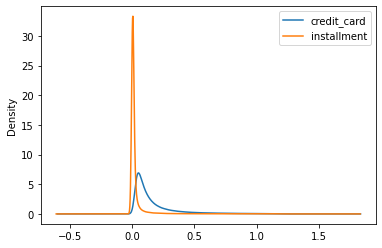

In [9]:
df.groupby('product_type')['score_5'].plot(kind='density', legend=True)

### Distribution of Scores

- Installment scores have a more narrow distribution with a long tail, whereas credit card scores are more widely distributed, and peak later too. 

<AxesSubplot:xlabel='product_type', ylabel='score_5'>

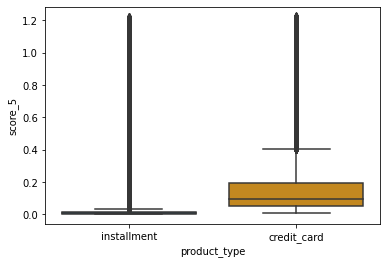

In [10]:
sns.boxplot(y='score_5', x='product_type', 
                 data=df, 
                 palette="colorblind")

Boxplots confirm the wider distribution of credit card scores. 

In [13]:
100*df_creditcard['suspected_fraud'].sum()/len(df_creditcard.index)

0.9110621162150836

In [44]:
100*df_loans['suspected_fraud'].sum()/len(df_loans.index)

2.2625688879872876

The fraud rate in credit cards is much lower than the fraud rate in loans. 

In [11]:
df_loans['score_decile'] = pd.qcut(df_loans['score_5'], 10, labels=False)

In [52]:
#df_loans.groupby('score_decile').apply(lambda x: x['suspected_fraud'].sum()/len(x.index))

In [14]:
df_creditcard['score_decile'] = pd.qcut(df_creditcard['score_5'], 10, labels=False)

In [53]:
#df_creditcard.groupby('score_decile').apply(lambda x: x['suspected_fraud'].sum()/len(x.index))

In [16]:
def decile_evaluator(dframe):
    min_decile = min(dframe['score_5'])
    max_decile = max(dframe['score_5'])
    avg_score_decile = dframe['score_5'].sum()/len(dframe.index)
    total_apps = len(dframe.index)
    total_fraud = dframe['suspected_fraud'].sum()
    fraud_rate = dframe['suspected_fraud'].sum()/len(dframe.index)
    return pd.Series({'min_decile': min_decile,
                     'max_decile':max_decile,
                      'avg_score_decile':avg_score_decile,
                     'total_apps':total_apps,
                     'total_fraud':total_fraud,
                     'fraud_rate':fraud_rate})

    

In [17]:
decile_stats_creditcard = df_creditcard.groupby('score_decile', as_index = False).apply(decile_evaluator)

In [18]:
decile_stats_creditcard['product'] = "creditcard"
decile_stats_creditcard

,score_decile,min_decile,max_decile,avg_score_decile,total_apps,total_fraud,fraud_rate,product
0,0,0.009090,0.035712,0.027584,32929.0,43.0,0.001306,creditcard
1,1,0.035712,0.048716,0.042236,32929.0,51.0,0.001549,creditcard
2,2,0.048716,0.062296,0.055365,32928.0,67.0,0.002035,creditcard
3,3,0.062297,0.078247,0.070012,32929.0,75.0,0.002278,creditcard
4,4,0.078247,0.098317,0.087863,32928.0,78.0,0.002369,creditcard
5,5,0.098317,0.125779,0.111318,32929.0,115.0,0.003492,creditcard
6,6,0.125779,0.166433,0.144578,32928.0,135.0,0.004100,creditcard
7,7,0.166438,0.237124,0.197997,32929.0,180.0,0.005466,creditcard
8,8,0.237126,0.395729,0.303466,32928.0,302.0,0.009172,creditcard
9,9,0.395730,1.224765,0.654674,32929.0,1954.0,0.059340,creditcard


In [19]:
decile_stats_loans = df_loans.groupby('score_decile', as_index = False).apply(decile_evaluator)

In [20]:
decile_stats_loans['product'] = "loan"
decile_stats_loans

,score_decile,min_decile,max_decile,avg_score_decile,total_apps,total_fraud,fraud_rate,product
0,0,0.002094,0.003202,0.002833,44366.0,188.0,0.004237,loan
1,1,0.003202,0.003870,0.003533,44365.0,231.0,0.005207,loan
2,2,0.003870,0.004643,0.004244,44366.0,227.0,0.005117,loan
3,3,0.004643,0.005635,0.005116,44365.0,233.0,0.005252,loan
4,4,0.005635,0.007021,0.006286,44366.0,285.0,0.006424,loan
5,5,0.007021,0.009137,0.007996,44365.0,320.0,0.007213,loan
6,6,0.009137,0.012834,0.010790,44365.0,467.0,0.010526,loan
7,7,0.012834,0.020635,0.016164,44366.0,577.0,0.013005,loan
8,8,0.020635,0.048594,0.030842,44365.0,945.0,0.021301,loan
9,9,0.048595,1.221209,0.257275,44366.0,6565.0,0.147974,loan


### Decile Analysis

- The difference in distribution of scores between credit card and installment loans is apparent when we break the scores down by decile. With loans, almost 80% of loans are scored under 0.05 (the cutoff point), whereas for credit cards, only ~15% score below 0.05. 


In [21]:
combined_product_stats = decile_stats_loans.append(decile_stats_creditcard)

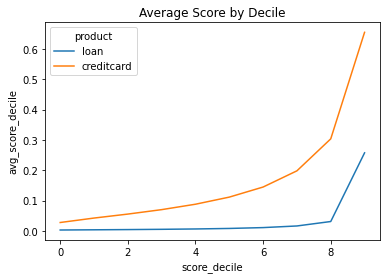

In [46]:
sns.lineplot(x='score_decile', 
             y='avg_score_decile',
             hue='product',
             data=combined_product_stats)
plt.title("Average Score by Decile")
plt.show()

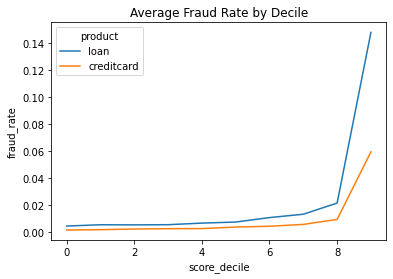

In [47]:
sns.lineplot(x='score_decile', 
             y='fraud_rate',
             hue='product',
             data=combined_product_stats)
plt.title("Average Fraud Rate by Decile")
plt.show()

In [24]:
def threshold_evaluator(dframe, threshold, ytrue = YTRUE_COL, ypred = YPRED_COL, scores = SCORE_COL):
    
    dframe[ypred] = np.where(100*dframe[scores] > threshold, 1, 0)
    #using scores to create threshold
    #false positives, true negatives for false positive rate
    true_positives = (dframe[ytrue] * dframe[ypred]).sum()
    false_positives = ((1-dframe[ytrue]) * dframe[ypred]).sum()
    false_negatives =  (dframe[ytrue] * (1-dframe[ypred])).sum()
    true_negatives = ((1-dframe[ytrue]) * (1-dframe[ypred])).sum()
    #calculating multiple metrics
    total_apps = len(dframe.index)
    actual_fraud = dframe[ytrue].sum()
    predicted_fraud = dframe[ypred].sum()
    precision = precision_score(y_true = dframe[ytrue], y_pred = dframe[ypred], pos_label = 1, zero_division = 0)
    recall = recall_score(y_true = dframe[ytrue], y_pred = dframe[ypred], pos_label = 1, zero_division = 0)
    false_positive_rate = false_positives/(false_positives+true_negatives)
    f1score = f1_score(y_true = dframe[ytrue], y_pred = dframe[ypred], pos_label = 1)

    return pd.Series({'threshold':threshold,'total_applications':total_apps,'actual_fraud':actual_fraud, 'predicted_fraud': predicted_fraud,
                      'precision': precision, 'recall': recall, 'f1score': f1score, 
                    'false_positive_rate':false_positive_rate
                     })


In [25]:
counter = range(0, 121)
test_list = []
for i in counter:
    test_list.append(threshold_evaluator(dframe = df_creditcard, threshold = i))
    
creditcard_output = pd.DataFrame(test_list)

In [26]:
counter = range(0, 121)
test_list = []
for i in counter:
    test_list.append(threshold_evaluator(dframe = df_loans, threshold = i))
    
installment_output = pd.DataFrame(test_list)

In [50]:
installment_output.head(20)

,threshold,total_applications,actual_fraud,predicted_fraud,precision,recall,f1score,false_positive_rate
0,0.0,443655.0,10038.0,443655.0,0.022626,1.000000,0.044250,1.000000
1,1.0,443655.0,10038.0,164414.0,0.051151,0.837816,0.096416,0.359774
2,2.0,443655.0,10038.0,91132.0,0.082814,0.751843,0.149194,0.192762
3,3.0,443655.0,10038.0,65021.0,0.108873,0.705220,0.188625,0.133625
4,4.0,443655.0,10038.0,51493.0,0.131649,0.675334,0.220344,0.103119
5,5.0,443655.0,10038.0,43374.0,0.150482,0.650229,0.244402,0.084976
6,6.0,443655.0,10038.0,37636.0,0.168535,0.631899,0.266099,0.072167
7,7.0,443655.0,10038.0,33463.0,0.184682,0.615660,0.284131,0.062920
8,8.0,443655.0,10038.0,30294.0,0.200172,0.604104,0.300704,0.055879
9,9.0,443655.0,10038.0,27761.0,0.214257,0.592548,0.314717,0.050305


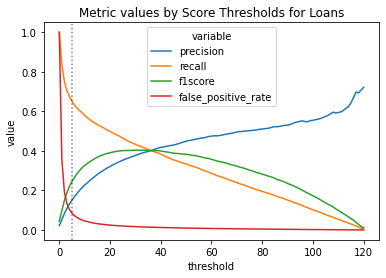

In [51]:
test = pd.melt(installment_output, 'threshold').query('variable == "recall" | variable == "precision" | variable == "f1score"| variable == "false_positive_rate"')
sns.lineplot('threshold', 'value', hue='variable', data=test)
plt.axvline(5, 0,1, alpha = 0.5, linestyle = ':', color = "black")

plt.title("Metric values by Score Thresholds for Loans")
plt.show()

In [62]:
creditcard_output.query('threshold > 0').head(20)

,threshold,total_applications,actual_fraud,predicted_fraud,precision,recall,f1score,false_positive_rate
1,1.0,329286.0,3000.0,329275.0,0.009111,1.000000,0.018057,0.999966
2,2.0,329286.0,3000.0,325543.0,0.009191,0.997333,0.018214,0.988553
3,3.0,329286.0,3000.0,309512.0,0.009599,0.990333,0.019014,0.939486
4,4.0,329286.0,3000.0,285742.0,0.010289,0.980000,0.020364,0.866730
5,5.0,329286.0,3000.0,260155.0,0.011120,0.964333,0.021987,0.788456
6,6.0,329286.0,3000.0,235846.0,0.012097,0.951000,0.023890,0.714076
7,7.0,329286.0,3000.0,213810.0,0.013072,0.931667,0.025783,0.646718
8,8.0,329286.0,3000.0,194336.0,0.014202,0.920000,0.027973,0.587141
9,9.0,329286.0,3000.0,177276.0,0.015326,0.905667,0.030143,0.534988
10,10.0,329286.0,3000.0,162313.0,0.016505,0.893000,0.032411,0.489246


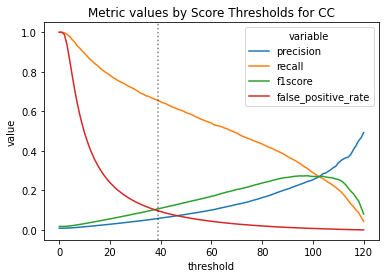

In [48]:
test = pd.melt(creditcard_output, 'threshold').query('variable == "recall" | variable == "precision" | variable == "f1score"| variable == "false_positive_rate"')
sns.lineplot('threshold', 'value', hue='variable', data=test)
plt.axvline(39, 0,1, alpha = 0.5, linestyle = ':', color = "black")

plt.title("Metric values by Score Thresholds for CC")
plt.show()

### Threshold Analysis

- The current cutoff of **0.05** captures 65% of all loan fraud (recall), marking 8.5% of negatives as fraud (false positives). Applying the same cutoff to credit cards, while it would capture 97% of fraud, would also flag 78% of negatives (good applications). 
- To achieve a similar outcome (similar to 0.05 with UIL) with credit cards, we can choose a cutoff between **0.38 - 0.40**, where we would capture 65% of all credit card fraud (recall), marking 9% of negatives as fraud (false positives). 

